#Imports

INSTALL MORE RECENT LIGHTGBM VERSION

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM

In [ ]:
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

In [3]:
import lightgbm as lgbm

In [4]:
print(lgbm.__version__) # check version to be sure.

3.3.2.99


In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
#import lightgbm # this imports lightgbm version 2.2.3, which does not support some pretty nice features.
import matplotlib.pyplot as plt
from math import log10


#Loading and checking data

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [6]:
df = pd.read_csv('drive/MyDrive/training_set_VU_DM.csv')#, nrows=100000)

In [7]:
df['price_usd'].replace(to_replace=0.0, value=1, inplace=True) # some prices are 0.0, which is weird. replace with 0.1 for the log function
df['price_usd'] = df['price_usd'].apply(log10)

df['visitor_hist_adr_usd'].replace(to_replace=0.0, value=1, inplace=True) # some prices are 0.0, which is weird.
df['visitor_hist_adr_usd'] = df['visitor_hist_adr_usd'].apply(log10)

In [8]:
### feature which highlights difference between the visitors historical data and the hotel cost
df['usd_diff'] = np.abs(df.visitor_hist_adr_usd.values - df.price_usd.values)
df['star_diff'] = np.abs(df.visitor_hist_starrating.values - df.prop_starrating.values)

Code below adds a ranking based on the price_usd feature, seems to decrease/keep performance the same

In [21]:
df_test = pd.read_csv('drive/MyDrive/test_set_VU_DM.csv')#, nrows=10000)

In [16]:
df_test['price_usd'].replace(to_replace=0.0, value=1, inplace=True) # some prices are 0.0, which is weird. replace with 0.1 for the log function
df_test['price_usd'] = df_test['price_usd'].apply(log10)

df_test['visitor_hist_adr_usd'].replace(to_replace=0.0, value=1, inplace=True) # some prices are 0.0, which is weird.
df_test['visitor_hist_adr_usd'] = df_test['visitor_hist_adr_usd'].apply(log10)

In [17]:
### feature which highlights difference between the visitors historical data and the hotel cost
df_test['usd_diff'] = np.abs(df_test.visitor_hist_adr_usd.values - df_test.price_usd.values)
df_test['star_diff'] = np.abs(df_test.visitor_hist_starrating.values - df_test.prop_starrating.values)

#Making Training and evaluation data for the model

Adding mean property price as a feature to dataset

In [9]:
def get_from_dict(x, _dict):
    '''There might be a better way to do this'''
    return _dict[x]


### mean and std of 'price_usd' feature per prop_id ###
same_vals_df = pd.DataFrame()
_dict = df.groupby('prop_id')['price_usd'].mean().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df['same_val_'+'prop_id'+'_'+'price_usd'+'_'+'avg'] = df['prop_id'].apply(get_from_dict, _dict=_dict)
df = pd.concat([df, same_vals_df.set_index(df.index)], axis=1)

same_vals_df = pd.DataFrame()
_dict = df.groupby('prop_id')['price_usd'].std().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df['same_val_'+'prop_id'+'_'+'price_usd'+'_'+'std'] = df['prop_id'].apply(get_from_dict, _dict=_dict)
df = pd.concat([df, same_vals_df.set_index(df.index)], axis=1)

'''
### mean and std of 'prop_starrating' feature ###
same_vals_df = pd.DataFrame()
_dict = df.groupby('prop_id')['prop_starrating'].mean().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df['same_val_'+'prop_id'+'_'+'prop_starrating'+'_'+'avg'] = df['prop_id'].apply(get_from_dict, _dict=_dict)
df = pd.concat([df, same_vals_df.set_index(df.index)], axis=1)

same_vals_df = pd.DataFrame()
_dict = df.groupby('prop_id')['prop_starrating'].std().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df['same_val_'+'prop_id'+'_'+'prop_starrating'+'_'+'std'] = df['prop_id'].apply(get_from_dict, _dict=_dict)
df = pd.concat([df, same_vals_df.set_index(df.index)], axis=1)

### mean and std of 'prop_review_score' feature ###
same_vals_df = pd.DataFrame()
_dict = df.groupby('prop_id')['prop_review_score'].mean().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df['same_val_'+'prop_id'+'_'+'prop_review_score'+'_'+'avg'] = df['prop_id'].apply(get_from_dict, _dict=_dict)
df = pd.concat([df, same_vals_df.set_index(df.index)], axis=1)

same_vals_df = pd.DataFrame()
_dict = df.groupby('prop_id')['prop_review_score'].std().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df['same_val_'+'prop_id'+'_'+'prop_review_score'+'_'+'std'] = df['prop_id'].apply(get_from_dict, _dict=_dict)
df = pd.concat([df, same_vals_df.set_index(df.index)], axis=1)

### mean and std of 'prop_log_historical_price' feature ###
same_vals_df = pd.DataFrame()
_dict = df.groupby('prop_id')['prop_log_historical_price'].mean().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df['same_val_'+'prop_id'+'_'+'prop_log_historical_price'+'_'+'avg'] = df['prop_id'].apply(get_from_dict, _dict=_dict)
df = pd.concat([df, same_vals_df.set_index(df.index)], axis=1)

same_vals_df = pd.DataFrame()
_dict = df.groupby('prop_id')['prop_log_historical_price'].std().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df['same_val_'+'prop_id'+'_'+'prop_log_historical_price'+'_'+'std'] = df['prop_id'].apply(get_from_dict, _dict=_dict)
df = pd.concat([df, same_vals_df.set_index(df.index)], axis=1)
'''

"\n### mean and std of 'prop_starrating' feature ###\nsame_vals_df = pd.DataFrame()\n_dict = df.groupby('prop_id')['prop_starrating'].mean().to_dict() # A dict with the operation applied to each group of the id \nsame_vals_df['same_val_'+'prop_id'+'_'+'prop_starrating'+'_'+'avg'] = df['prop_id'].apply(get_from_dict, _dict=_dict)\ndf = pd.concat([df, same_vals_df.set_index(df.index)], axis=1)\n\nsame_vals_df = pd.DataFrame()\n_dict = df.groupby('prop_id')['prop_starrating'].std().to_dict() # A dict with the operation applied to each group of the id \nsame_vals_df['same_val_'+'prop_id'+'_'+'prop_starrating'+'_'+'std'] = df['prop_id'].apply(get_from_dict, _dict=_dict)\ndf = pd.concat([df, same_vals_df.set_index(df.index)], axis=1)\n\n### mean and std of 'prop_review_score' feature ###\nsame_vals_df = pd.DataFrame()\n_dict = df.groupby('prop_id')['prop_review_score'].mean().to_dict() # A dict with the operation applied to each group of the id \nsame_vals_df['same_val_'+'prop_id'+'_'+'prop_

for test set

In [18]:
def get_from_dict(x, _dict):
    '''There might be a better way to do this'''
    return _dict[x]

### mean and std of 'price_usd' feature ###
same_vals_df_test = pd.DataFrame()
_dict = df_test.groupby('prop_id')['price_usd'].mean().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df_test['same_val_'+'prop_id'+'_'+'price_usd'+'_'+'avg'] = df_test['prop_id'].apply(get_from_dict, _dict=_dict)
df_test = pd.concat([df_test, same_vals_df_test.set_index(df_test.index)], axis=1)

same_vals_df_test = pd.DataFrame()
_dict = df_test.groupby('prop_id')['price_usd'].std().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df_test['same_val_'+'prop_id'+'_'+'price_usd'+'_'+'std'] = df_test['prop_id'].apply(get_from_dict, _dict=_dict)
df_test = pd.concat([df_test, same_vals_df_test.set_index(df_test.index)], axis=1)

'''
### mean and std of 'prop_starrating' feature ###
same_vals_df_test = pd.DataFrame()
_dict = df_test.groupby('prop_id')['prop_starrating'].mean().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df_test['same_val_'+'prop_id'+'_'+'prop_starrating'+'_'+'avg'] = df_test['prop_id'].apply(get_from_dict, _dict=_dict)
df_test = pd.concat([df_test, same_vals_df_test.set_index(df_test.index)], axis=1)

same_vals_df_test = pd.DataFrame()
_dict = df_test.groupby('prop_id')['prop_starrating'].std().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df_test['same_val_'+'prop_id'+'_'+'prop_starrating'+'_'+'std'] = df_test['prop_id'].apply(get_from_dict, _dict=_dict)
df_test = pd.concat([df_test, same_vals_df_test.set_index(df_test.index)], axis=1)

### mean and std of 'prop_review_score' feature ###
same_vals_df_test = pd.DataFrame()
_dict = df_test.groupby('prop_id')['prop_review_score'].mean().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df_test['same_val_'+'prop_id'+'_'+'prop_review_score'+'_'+'avg'] = df_test['prop_id'].apply(get_from_dict, _dict=_dict)
df_test = pd.concat([df_test, same_vals_df_test.set_index(df_test.index)], axis=1)

same_vals_df_test = pd.DataFrame()
_dict = df_test.groupby('prop_id')['prop_review_score'].std().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df_test['same_val_'+'prop_id'+'_'+'prop_review_score'+'_'+'std'] = df_test['prop_id'].apply(get_from_dict, _dict=_dict)
df_test = pd.concat([df_test, same_vals_df_test.set_index(df_test.index)], axis=1)

### mean and std of 'prop_log_historical_price' feature ###
same_vals_df_test = pd.DataFrame()
_dict = df_test.groupby('prop_id')['prop_log_historical_price'].mean().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df_test['same_val_'+'prop_id'+'_'+'prop_log_historical_price'+'_'+'avg'] = df_test['prop_id'].apply(get_from_dict, _dict=_dict)
df_test = pd.concat([df_test, same_vals_df_test.set_index(df_test.index)], axis=1)

same_vals_df_test = pd.DataFrame()
_dict = df_test.groupby('prop_id')['prop_log_historical_price'].std().to_dict() # A dict with the operation applied to each group of the id 
same_vals_df_test['same_val_'+'prop_id'+'_'+'prop_log_historical_price'+'_'+'std'] = df_test['prop_id'].apply(get_from_dict, _dict=_dict)
df_test = pd.concat([df_test, same_vals_df_test.set_index(df_test.index)], axis=1)
'''

"\n### mean and std of 'prop_starrating' feature ###\nsame_vals_df_test = pd.DataFrame()\n_dict = df_test.groupby('prop_id')['prop_starrating'].mean().to_dict() # A dict with the operation applied to each group of the id \nsame_vals_df_test['same_val_'+'prop_id'+'_'+'prop_starrating'+'_'+'avg'] = df_test['prop_id'].apply(get_from_dict, _dict=_dict)\ndf_test = pd.concat([df_test, same_vals_df_test.set_index(df_test.index)], axis=1)\n\nsame_vals_df_test = pd.DataFrame()\n_dict = df_test.groupby('prop_id')['prop_starrating'].std().to_dict() # A dict with the operation applied to each group of the id \nsame_vals_df_test['same_val_'+'prop_id'+'_'+'prop_starrating'+'_'+'std'] = df_test['prop_id'].apply(get_from_dict, _dict=_dict)\ndf_test = pd.concat([df_test, same_vals_df_test.set_index(df_test.index)], axis=1)\n\n### mean and std of 'prop_review_score' feature ###\nsame_vals_df_test = pd.DataFrame()\n_dict = df_test.groupby('prop_id')['prop_review_score'].mean().to_dict() # A dict with the

In [10]:
### so i want to fill the competition NaN values with 0s
### all other variables i will set NaNs to -10
comp_columnns = [comp_col for comp_col in df.columns if comp_col.startswith('comp')]
df[comp_columnns] = df[comp_columnns].fillna(0)
df = df.fillna(-10)

for test set!

In [19]:
comp_columnns = [comp_col for comp_col in df_test.columns if comp_col.startswith('comp')]
df_test[comp_columnns] = df_test[comp_columnns].fillna(0)
df_test = df_test.fillna(-10)
df_test = df_test.drop(['date_time', 'site_id', 'random_bool', 'srch_id', 'prop_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd'], axis=1, inplace=False)

In [11]:
df_train = df[:4500000]
df_eval = df[4500000:]

qids_train = df_train.groupby('srch_id')['srch_id'].count().to_numpy()
y_train = 5 * df_train['booking_bool'].values + df_train['click_bool'].values # booking_bool weighs for 5, clicking bool for 1
X_train = df_train.drop(['date_time', 'random_bool', 'click_bool', 'booking_bool', 'position', 'site_id', 'gross_bookings_usd', 'srch_id', 'prop_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd'], axis=1) # 

qids_eval = df_eval.groupby('srch_id')['srch_id'].count().to_numpy()
y_eval = 5 * df_eval['booking_bool'].values + df_eval['click_bool'].values
X_eval = df_eval.drop(['date_time', 'random_bool', 'click_bool', 'booking_bool', 'position', 'site_id', 'gross_bookings_usd', 'srch_id', 'prop_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd'], axis=1) # 

#Training a simple lightgbm model with the objective lambdaRank

In [12]:
### original model, parameters = score of ¬ 0.399

model = lgbm.LGBMRanker(objective='lambdarank', metric='ndcg', boosting='dart',
                        num_leaves=255, min_data_in_leaf=1, min_sum_hessian_in_leaf=100, n_estimators=1000,
                        num_iterations=1000, learning_rate=0.03, early_stopping_rounds=65, device_type='gpu', seed=42)
model.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    eval_set=[(X_eval, y_eval)],
    eval_group=[qids_eval],
    eval_at=[5, 38],
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:136: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] early_stopping_round is set=65, early_stopping_rounds=65 will be ignored. Current value: early_stopping_round=65
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4468
[LightGBM] [Info] Number of data points in the train

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:265: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


LGBMRanker(boosting='dart', device_type='gpu', early_stopping_rounds=65,
           learning_rate=0.03, metric='ndcg', min_data_in_leaf=1,
           min_sum_hessian_in_leaf=100, n_estimators=1000, num_iterations=1000,
           num_leaves=255, objective='lambdarank', seed=42)

In [13]:
model.booster_.save_model('drive/MyDrive/mode.txt')


In [14]:
del df, df_eval,df_train,qids_eval, qids_train, same_vals_df, X_eval, X_train, y_eval, y_train # delete from memory after training to prevent runtime crashes and restarts 
#del df_test, X_test, results]


#Making predictions to rank prop_ids by srch_ids

THIS IS FOR THE lightGBM MODEL

In [20]:
results = model.predict(df_test)
print(len(results.tolist()))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
4959183


##making new dataframe to eventually export to csv

In [22]:
new_df = df_test[['prop_id', 'srch_id']]
new_df['predictions'] = results
print(new_df.head(30))

    prop_id  srch_id  predictions
0      3180        1     0.031138
1      5543        1    -0.015777
2     14142        1    -0.275149
3     22393        1    -0.332802
4     24194        1     0.538116
5     28181        1     0.549874
6     34263        1     0.507006
7     37567        1    -0.215619
8     50162        1     0.132004
9     54937        1     0.815595
10    56050        1    -0.933870
11    61632        1    -1.279353
12    61934        1     0.893714
13    63894        1     0.164642
14    72090        1    -0.334717
15    73666        1    -0.315379
16    74045        1     0.214375
17    78599        1     0.029200
18    82231        1     0.207770
19    89466        1    -0.375336
20    90385        1     0.201752
21    94729        1    -0.092346
22    95031        1     0.426590
23    99484        1     1.010831
24   123675        1     0.115273
25   128085        1    -0.246644
26   128871        1    -0.666324
27   134992        1    -1.104708
28   139162   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
sorted_df = new_df.sort_values(['srch_id', 'predictions'], ascending=[True, False])
print(sorted_df.head(30))

    prop_id  srch_id  predictions
23    99484        1     1.010831
12    61934        1     0.893714
9     54937        1     0.815595
5     28181        1     0.549874
4     24194        1     0.538116
6     34263        1     0.507006
22    95031        1     0.426590
16    74045        1     0.214375
18    82231        1     0.207770
20    90385        1     0.201752
13    63894        1     0.164642
8     50162        1     0.132004
24   123675        1     0.115273
0      3180        1     0.031138
17    78599        1     0.029200
1      5543        1    -0.015777
21    94729        1    -0.092346
7     37567        1    -0.215619
25   128085        1    -0.246644
2     14142        1    -0.275149
15    73666        1    -0.315379
3     22393        1    -0.332802
14    72090        1    -0.334717
19    89466        1    -0.375336
28   139162        1    -0.630825
26   128871        1    -0.666324
10    56050        1    -0.933870
27   134992        1    -1.104708
11    61632   

Export the predictions csv


In [24]:
export_df = sorted_df.drop(['predictions'], axis=1)
export_df = export_df[['srch_id', 'prop_id']] # swap columns for required format

compression_opts = dict(method='zip', archive_name='out.csv')  
export_df.to_csv('out.zip', index=False, compression=compression_opts) # we can submit .zip instead of the raw .csv, which saves some space.

In [ ]:
%matplotlib inline

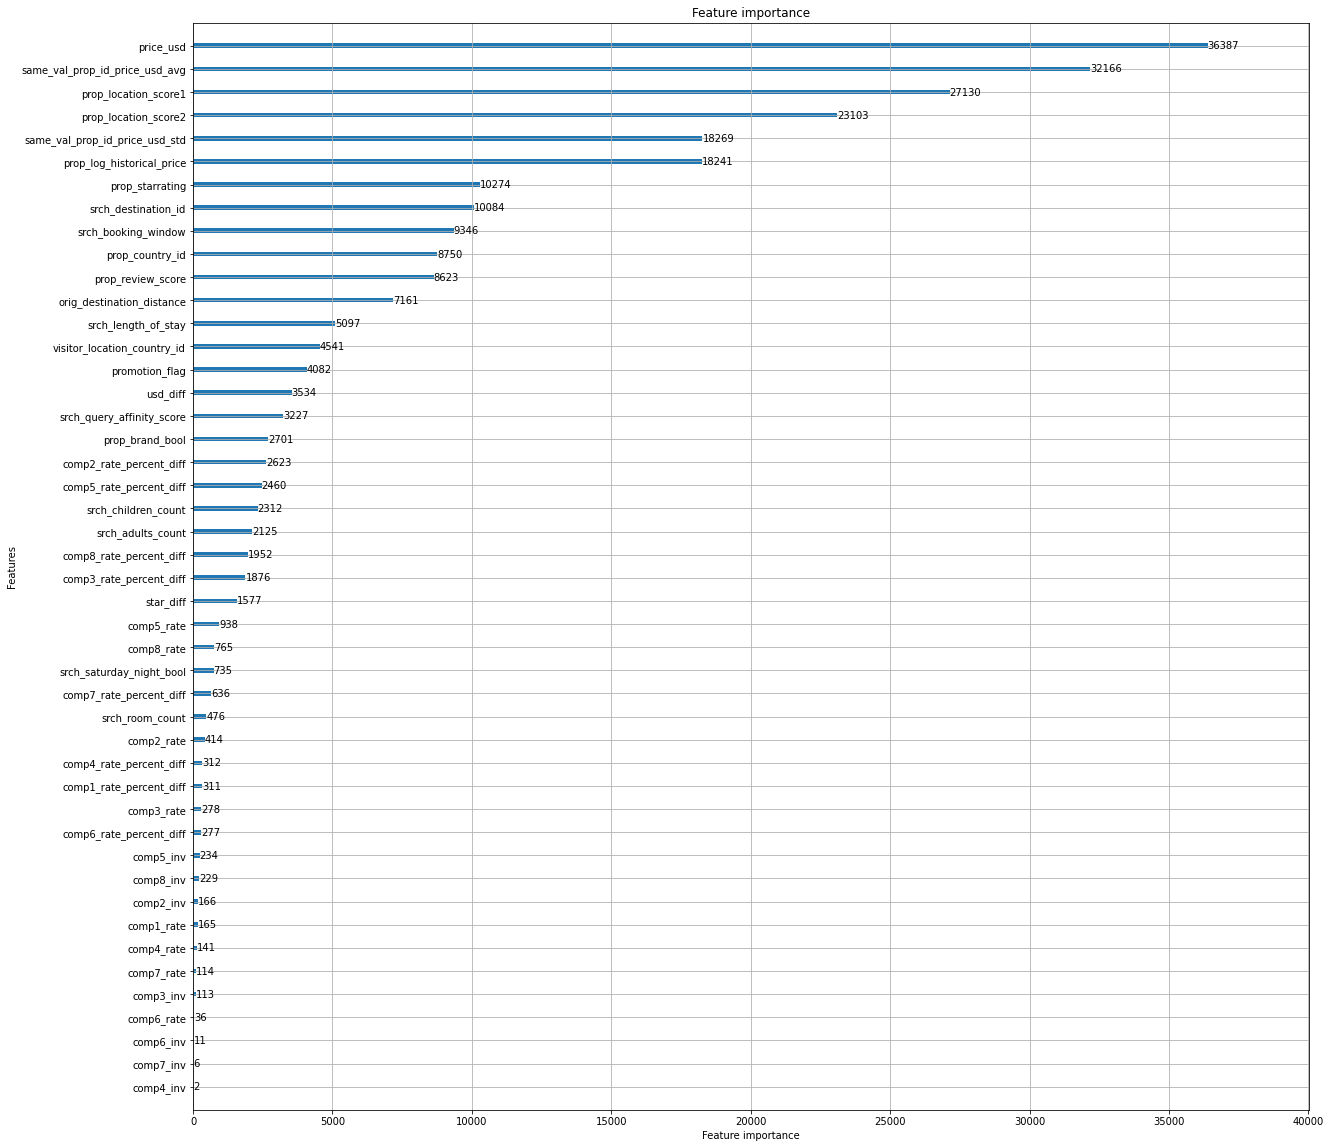

In [25]:
ax = lgbm.plot_importance(model)
fig = ax.figure
fig.set_size_inches(20,20)